# Imbalanced Dataset - (PCA & t-SNE)

PCA, t-SNE 모두 차원 축소 기법이다. 

이 2가지 특징과 차이점을 분명히 알아가자 

https://amazelimi.tistory.com/entry/PCA-vs-t-SNE


In [150]:
import os

import numpy as np 
# 데이터를 다루고 시각화 하기 위한 라이브러리 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D


from sklearn.metrics import roc_auc_score               # auc 계산
from imblearn.over_sampling import SMOTE                # over sampling을 위해 
from sklearn.model_selection import train_test_split    # trainset과 testset 나누기 위해


# Section 1 

PCA가 무엇인지, 그리고 '차원의 저주'로 널리 알려진 데이터 세트의 열 수를 실제로 어떻게 줄이는지 시각화하고 설명

t-SNE를 사용하여 고차원 데이터 세트를 시각화하여 데이터가 실제로 분리 가능한지 여부를 시각적으로 확인합니다. 마지막으로 PCA를 사용한 다음 t-SNE를 사용하여 데이터를 시각화합니다.

In [151]:
data_base_path = './data'

test_data_path = os.path.join(data_base_path, 'Test.csv')
train_data_path = os.path.join(data_base_path, 'Train.csv')
submit_path = os.path.join(data_base_path, 'Sample_submission.csv')

test = pd.read_csv(test_data_path)
train = pd.read_csv(train_data_path)
submit = pd.read_csv(submit_path)

# PCA for Dimensionality Reduction

PCA(Principal Component Analysis) 주성분 분석은 데이터 세트의 차원을 줄이는 데 사용되는 기술입니다.

즉, 데이터 세트의 컬럼 수를 줄이는 데 사용됩니다.

단순히 컬럼을 직접적으로 제거하는것이 아니라 고유값(Eigen values)와 고유벡터(Eigen vectors)를 사용하여 주 성분 축 (principal component axes)를 제거하는 수학적 방법으로 컬럼 수를 제거합니다.

우리가 얻은 이런 축들은 데이터셋의 정보를 많이 잃지 않으면서 데이터셋의 전체 분산을 설명하기에 좋습니다.

다시말해, 이러한 축들 또는 주요 구성 요소는 낮은 차원 공간에 대한 동등한 정보로 고차원 데이터를 표현하는 데 도움이 됩니다.

https://dacon.io/en/codeshare/4640


In [152]:
# 차원축소를 위해 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [153]:
# n_components 는 축소하고 싶은 차원의 수, 주성분을 몇개로 할지 결정
pca = PCA(n_components=3, random_state=52)

In [154]:
X = train.drop("Class", axis = 1)
y = train["Class"]

In [155]:
pca_result = pca.fit_transform(X)

In [156]:
print(pca.explained_variance_ratio_)

[8.66775545e-01 1.32078413e-01 5.75164405e-04]


In [157]:
train_copy = train.copy()
# 주요 성분 3개 
train_copy['pca-one'] = pca_result[:,0]
train_copy['pca-two'] = pca_result[:,1] 
train_copy['pca-three'] = pca_result[:,2]

<Axes: xlabel='pca-one', ylabel='pca-two'>

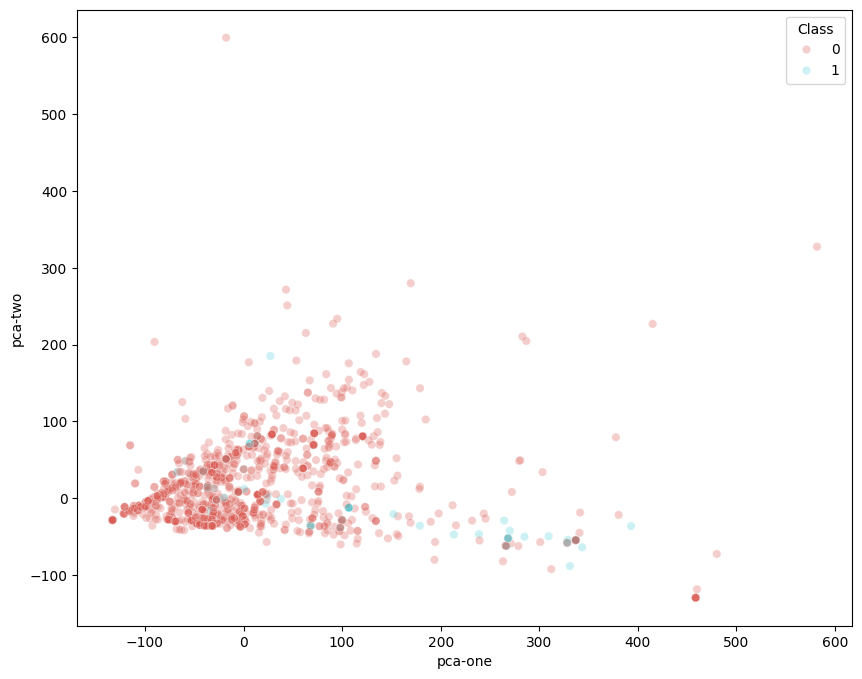

In [158]:
rndperm = np.random.permutation(train_copy.shape[0])
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data= train_copy.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

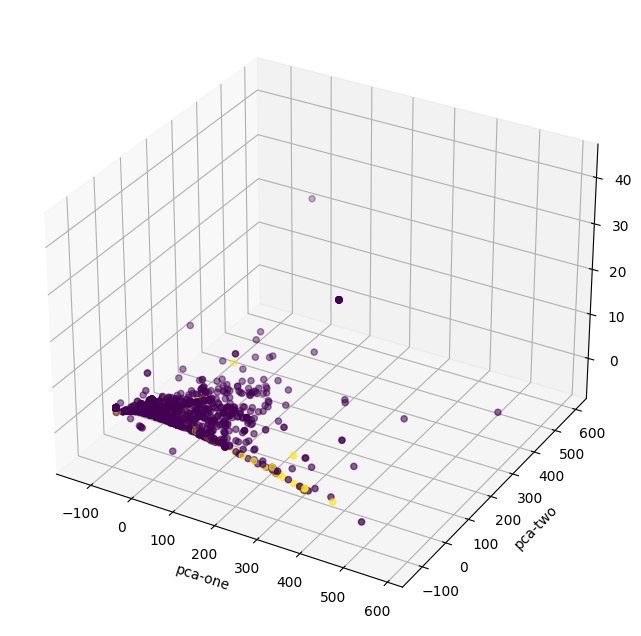

In [159]:
fig = plt.figure(figsize=(10, 8))

# 3D 서브플롯 추가
ax = fig.add_subplot(111, projection='3d')

# 3D 산점도 그리기
ax.scatter(
    xs=train_copy.loc[rndperm, :]["pca-one"], 
    ys=train_copy.loc[rndperm, :]["pca-two"], 
    zs=train_copy.loc[rndperm, :]["pca-three"], 
    c=train_copy.loc[rndperm,:]["Class"], 
    cmap='viridis'  # 또는 tab10, 'plasma', 'coolwarm' 
)

# 축 라벨 설정
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

# 그래프 출력
plt.show()

In [160]:
from scipy.cluster.vq import kmeans,vq

def kmeans_clus(df,not_x,not_y,k,cluster_label):
    df=df.copy()
    centroids,distortions=kmeans(df[[not_x,not_y]],k_or_guess=k)
    labels,_=vq(df[[not_x,not_y]],centroids)
    df[cluster_label]=labels
    sns.scatterplot(x=not_x,y=not_y,data=df,hue=cluster_label)
    # for i in range(k):
    #     plt.scatter(x=centroids[i,0],y=centroids[i,1],s=500,cmap='Cyan')


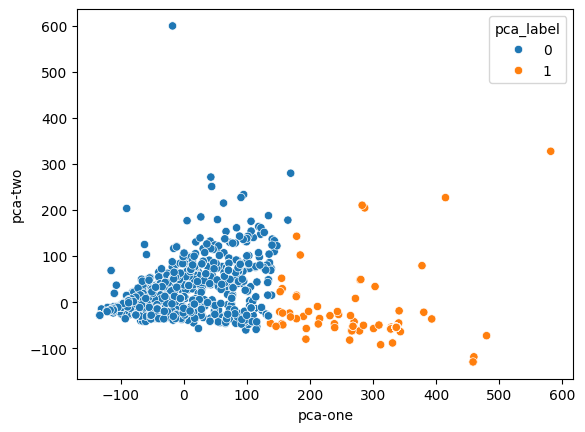

In [161]:
kmeans_clus(train_copy,'pca-one','pca-two', 2, 'pca_label')

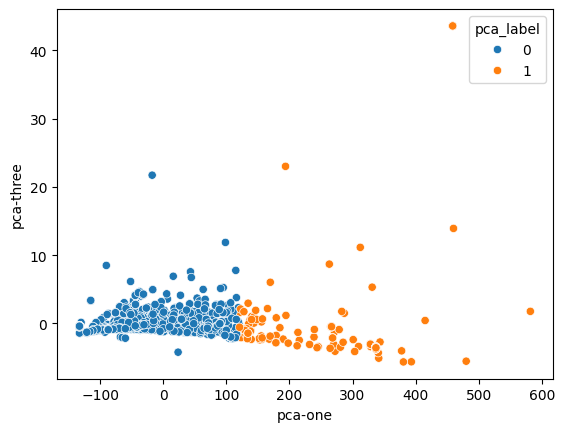

In [162]:
kmeans_clus(train_copy,'pca-one','pca-three', 2, 'pca_label')

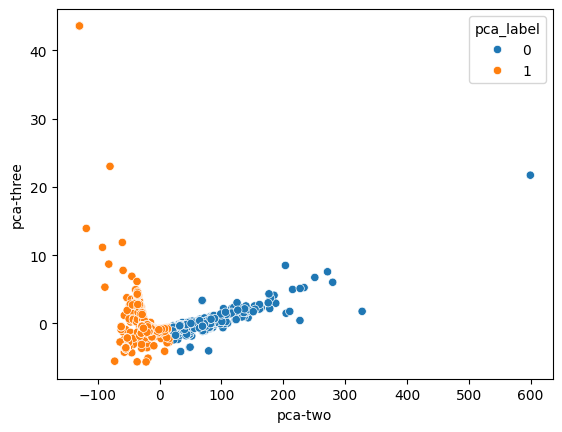

In [163]:
kmeans_clus(train_copy,'pca-two','pca-three', 2, 'pca_label')

feature를 10개까지 줄이고 모델링을 수행해보자.

In [164]:
pca_50 = PCA(n_components=10)               # 차원을 50개로 줄임 
X = train.drop("Class", axis = 1)
y = train["Class"]

pca_result_50 = pca_50.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))        # 50개의 주성분이 데이터의 분산(variance)을 얼마나 잘 설명하는지 계산


Cumulative explained variation for 50 principal components: 0.9995704048934085


In [165]:
train_copy2 = train.copy()
for i in range(10):
    train_copy2[f'pca-{i}'] = pca_result_50[:,i]

train_pca = train_copy2.iloc[:,-10:]

train_pca.head()

,pca-0,pca-1,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7,pca-8,pca-9
0,41.292096,40.178968,-0.870888,-0.383776,-0.212171,0.276571,-0.149780,-0.413447,-0.174372,0.080540
1,-48.821139,-24.732114,0.454829,-0.456164,-0.086869,-0.754306,1.704326,1.123471,-0.177134,0.074700
2,31.275886,40.994394,-0.749832,-0.357044,-0.285713,-0.337362,-0.192689,0.128910,0.180502,-0.125479
3,-87.556909,2.783249,-0.857480,-0.497424,-0.073902,-0.032457,0.338335,-0.457964,-0.375880,-0.002718
4,98.490388,-60.348215,11.860590,-1.112452,-0.129529,0.056474,-0.446286,0.044783,0.012713,0.346256


In [166]:
X_train, X_valid, y_train, y_valid = train_test_split(train_pca, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1410, 10), (353, 10), (1410,), (353,))

In [167]:
from sklearn.ensemble import RandomForestClassifier
import catboost
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

In [168]:
Rf = RandomForestClassifier()
model_Rf = Rf.fit(X_train, y_train)

# K-Fold CV로 성능을 검증
cv_score = cross_val_score(model_Rf, X_train, y_train, cv=10)
print('cv_score :', cv_score)
print('mean cv_score :', cv_score.mean())

# 4단계: 예측하기
y_pred = model_Rf.predict(X_valid)

# 5단계 평가하기
print(classification_report(y_valid, y_pred))
print('Acc Score :', accuracy_score(y_valid, y_pred))
print('AUC Score :', roc_auc_score(y_valid, y_pred))

cv_score : [0.91489362 0.94326241 0.89361702 0.89361702 0.88652482 0.93617021
 0.90070922 0.89361702 0.92198582 0.90780142]
mean cv_score : 0.9092198581560282
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       327
           1       0.38      0.38      0.38        26

    accuracy                           0.91       353
   macro avg       0.67      0.67      0.67       353
weighted avg       0.91      0.91      0.91       353

Acc Score : 0.9093484419263456
AUC Score : 0.6678428605034109


성능이 조금 좋아졌다.

## t-SNE

In [169]:
# 차원을 2차원으로 줄입니다.
X = train.drop("Class", axis = 1)
y = train["Class"]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1763 samples in 0.019s...
[t-SNE] Computed neighbors for 1763 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1763
[t-SNE] Computed conditional probabilities for sample 1763 / 1763
[t-SNE] Mean sigma: 2.367027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.249237
[t-SNE] KL divergence after 300 iterations: 0.923655


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

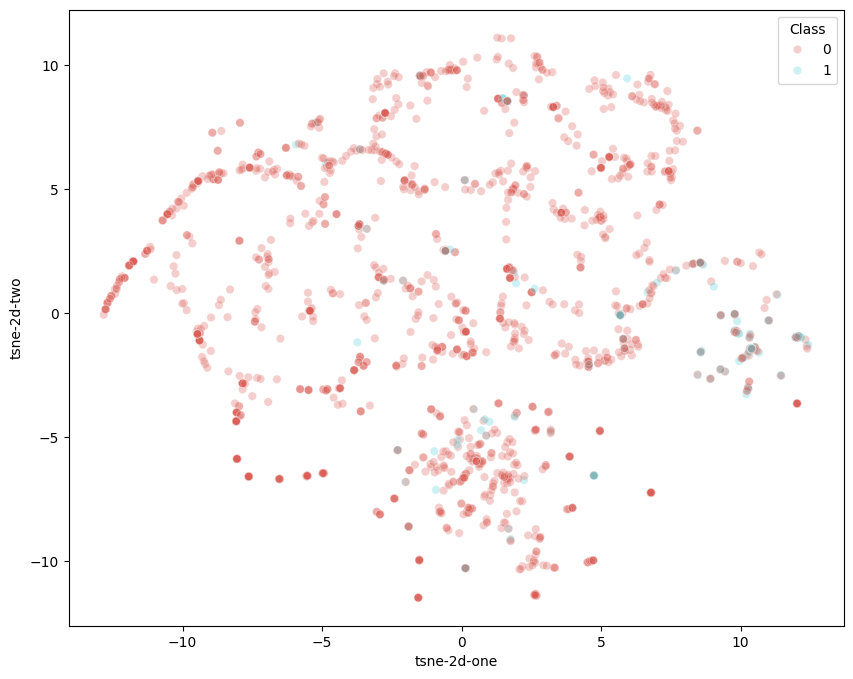

In [170]:
train_copy['tsne-2d-one'] = tsne_results[:,0]
train_copy['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data=train_copy,
    legend="full",
    alpha=0.3
)

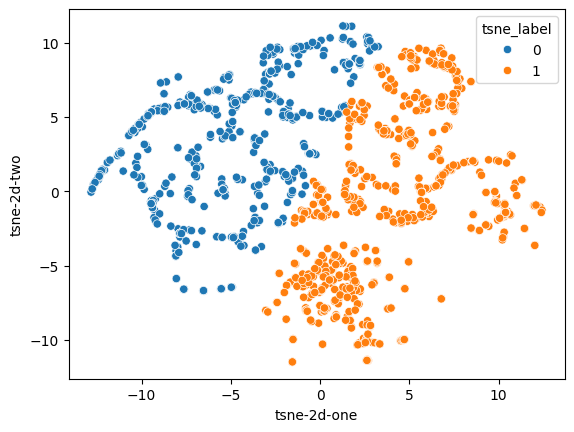

In [171]:
   
kmeans_clus(train_copy,'tsne-2d-one','tsne-2d-two', 2, 'tsne_label')

## Using PCA and t-SNE together

PCA의 축소된 차원을 사용하여 t-SNE를 사용하여 데이터를 시각화하겠습니다.

https://gaussian37.github.io/ml-concept-t_sne/

In [172]:
pca_50 = PCA(n_components=50)               # 차원을 50개로 줄임 
pca_result_50 = pca_50.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))        # 50개의 주성분이 데이터의 분산(variance)을 얼마나 잘 설명하는지 계산

# 각 주성분이 데이터의 전체 분산에서 차지하는 비율을 나타냅니다. 이 값은 각 주성분이 원본 데이터의 분산을 얼마나 잘 설명하는지를 보여줍니다.


Cumulative explained variation for 50 principal components: 0.9997638438305158


In [173]:
# 2차원 공간으로 변환
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_pca_results = tsne.fit_transform(pca_result_50)

'''
perplexity=40: t-SNE의 하이퍼파라미터로, 각 포인트의 지역적인 집단화를 측정하는 척도입니다. 일반적으로 데이터 크기에 따라 5에서 50 사이의 값을 사용합니다. 이 값은 데이터의 밀도에 영향을 미칩니다.
n_iter=1000: t-SNE 알고리즘이 최적화하는 동안 수행할 최대 반복(iteration) 횟수입니다. 일반적으로 1000번 이상의 반복을 수행하며, 이 값을 증가시키면 t-SNE가 더 잘 수렴할 가능성이 있습니다.
'''

'\nperplexity=40: t-SNE의 하이퍼파라미터로, 각 포인트의 지역적인 집단화를 측정하는 척도입니다. 일반적으로 데이터 크기에 따라 5에서 50 사이의 값을 사용합니다. 이 값은 데이터의 밀도에 영향을 미칩니다.\nn_iter=1000: t-SNE 알고리즘이 최적화하는 동안 수행할 최대 반복(iteration) 횟수입니다. 일반적으로 1000번 이상의 반복을 수행하며, 이 값을 증가시키면 t-SNE가 더 잘 수렴할 가능성이 있습니다.\n'

In [174]:

train_copy['tsne-pca50-one'] = tsne_pca_results[:,0]
train_copy['tsne-pca50-two'] = tsne_pca_results[:,1]

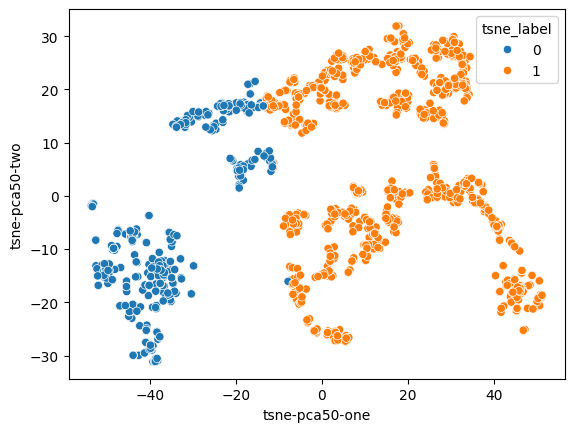

In [175]:
   
kmeans_clus(train_copy,'tsne-pca50-one','tsne-pca50-two', 2, 'tsne_label')

In [176]:
train_copy.head(2)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1557,feature_1558,Class,pca-one,pca-two,pca-three,tsne-2d-one,tsne-2d-two,tsne-pca50-one,tsne-pca50-two
0,100,160,1.60,0,0,0,0,0,0,0,...,0,0,0,41.292096,40.178968,-0.870888,2.236578,4.811057,19.485851,16.762440
1,20,83,4.15,1,0,0,0,0,0,1,...,0,0,0,-48.821139,-24.732114,0.454829,-7.329988,-2.604326,-5.763247,-15.299701


<Axes: xlabel='tsne-pca50-one', ylabel='tsne-pca50-two'>

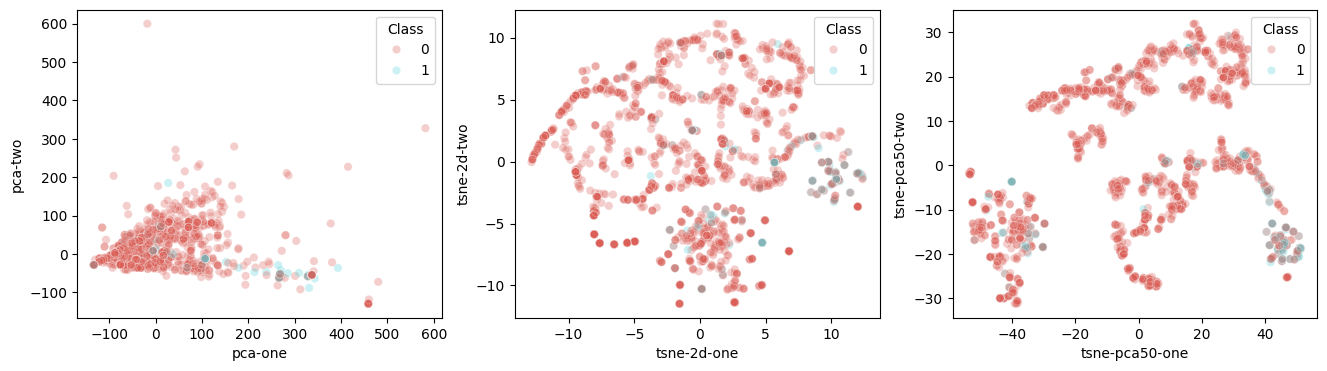

In [177]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data=train_copy,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data=train_copy,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data=train_copy,
    legend="full",
    alpha=0.3,
    ax=ax3
)

In [178]:
train_copy.head(2)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1557,feature_1558,Class,pca-one,pca-two,pca-three,tsne-2d-one,tsne-2d-two,tsne-pca50-one,tsne-pca50-two
0,100,160,1.60,0,0,0,0,0,0,0,...,0,0,0,41.292096,40.178968,-0.870888,2.236578,4.811057,19.485851,16.762440
1,20,83,4.15,1,0,0,0,0,0,1,...,0,0,0,-48.821139,-24.732114,0.454829,-7.329988,-2.604326,-5.763247,-15.299701


## 축소한 차원으로 실험하기 

In [179]:
# 1단계: 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [180]:
models = {
    "KNeighborsClassifier": {"model":KNeighborsClassifier()},
    "GaussianNB": {"model":GaussianNB()},
    "SVM": {"model":SVC(probability=True)},
    "DecisionTreeClassifier": {"model":DecisionTreeClassifier(random_state=0)},
    "LogisticRegression": {"model":LogisticRegression(random_state=0)},
    "RandomForestClassifier": {"model":RandomForestClassifier(random_state=0)},
    "XGBClassifier": {"model":XGBClassifier(random_state=0)},
    "LGBMClassifier": {"model":LGBMClassifier(random_state=0,verbose=-1)}
}

In [181]:
from time import perf_counter

def experiments(x_train, y_train, x_valid, y_valid):

    # Train모델 학습
    for name, model in models.items():
        model = model['model']
        start = perf_counter()

        history = model.fit(x_train, y_train)

        # 학습시간과 val_accuracy 저장
        duration = perf_counter() - start
        duration = round(duration,2)
        models[name]['perf'] = duration

        y_val_pred = model.predict(x_valid)

        val_score = roc_auc_score(y_valid, y_val_pred)

        models[name]['val_score'] = val_score

        print(f"{name:20} trained in {duration} sec, val_score: {val_score}")

    # Create a DataFrame with the results
    models_result = []

    for name, v in models.items():
        models_result.append([ name, models[name]['val_score'], models[name]['perf']])

    df_results = pd.DataFrame(models_result, 
                            columns = ['model','val_score','Training time (sec)'])
    df_results.sort_values(by='val_score', ascending=False, inplace=True)
    df_results.reset_index(inplace=True,drop=True)
    
    return df_results

In [182]:
def check_performance_for_model(df_results, version='val_score'):
    df_results = df_results.sort_values(by=version, ascending=False)
    palette = sns.color_palette("husl", len(df_results))
    plt.figure(figsize = (15,5))
    sns.barplot(x='model', y=version, data=df_results, palette=palette)
    plt.title('AUC on the Test set', fontsize = 15)
    plt.ylim(0,1.2)
    plt.xticks(rotation=90)
    plt.show()

## Oversampling 없이 실험

## 1. t-sne

In [183]:
X = train_copy[['tsne-2d-one', 'tsne-2d-two']]
y = train_copy["Class"]

In [184]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1410, 2), (353, 2), (1410,), (353,))

In [185]:
df_results = experiments(X_train, y_train, X_valid, y_valid)

df_results

KNeighborsClassifier trained in 0.0 sec, val_score: 0.6516701952481769
GaussianNB           trained in 0.0 sec, val_score: 0.5
SVM                  trained in 0.11 sec, val_score: 0.5
DecisionTreeClassifier trained in 0.01 sec, val_score: 0.6379087273582688
LogisticRegression   trained in 0.0 sec, val_score: 0.5
RandomForestClassifier trained in 0.27 sec, val_score: 0.6263232180663373
XGBClassifier        trained in 0.06 sec, val_score: 0.6709009644789461
LGBMClassifier       trained in 0.05 sec, val_score: 0.6632557045401082


,model,val_score,Training time (sec)
0,XGBClassifier,0.670901,0.06
1,LGBMClassifier,0.663256,0.05
2,KNeighborsClassifier,0.651670,0.00
3,DecisionTreeClassifier,0.637909,0.01
4,RandomForestClassifier,0.626323,0.27
5,GaussianNB,0.500000,0.00
6,SVM,0.500000,0.11
7,LogisticRegression,0.500000,0.00


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


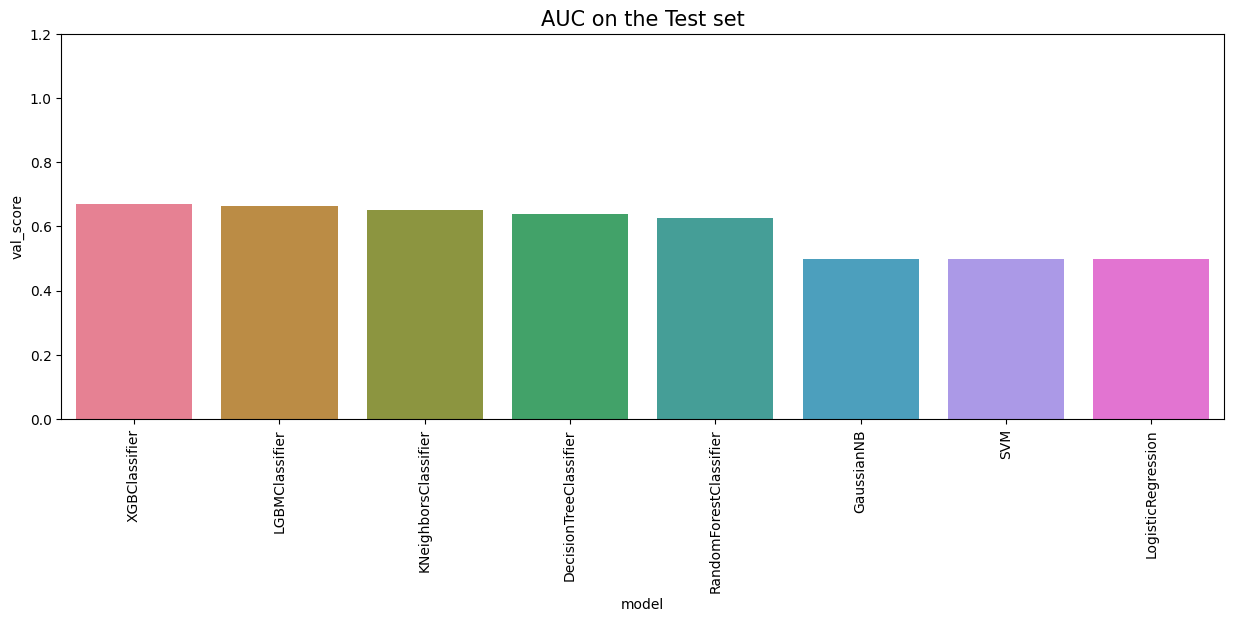

In [186]:
check_performance_for_model(df_results, version='val_score')

## 2. pca

In [187]:
X = train_copy[['pca-one', 'pca-two', 'pca-three']]
y = train_copy["Class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((1410, 3), (353, 3), (1410,), (353,))

In [188]:
df_results = experiments(X_train, y_train, X_valid, y_valid)

df_results

KNeighborsClassifier trained in 0.0 sec, val_score: 0.6531992472359446
GaussianNB           trained in 0.0 sec, val_score: 0.7417078334509526
SVM                  trained in 0.1 sec, val_score: 0.5
DecisionTreeClassifier trained in 0.01 sec, val_score: 0.673312161844272
LogisticRegression   trained in 0.01 sec, val_score: 0.4984709480122324
RandomForestClassifier trained in 0.28 sec, val_score: 0.6855445777464126
XGBClassifier        trained in 0.06 sec, val_score: 0.6501411432604094
LGBMClassifier       trained in 0.05 sec, val_score: 0.6647847565278757


,model,val_score,Training time (sec)
0,GaussianNB,0.741708,0.00
1,RandomForestClassifier,0.685545,0.28
2,DecisionTreeClassifier,0.673312,0.01
3,LGBMClassifier,0.664785,0.05
4,KNeighborsClassifier,0.653199,0.00
5,XGBClassifier,0.650141,0.06
6,SVM,0.500000,0.10
7,LogisticRegression,0.498471,0.01


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


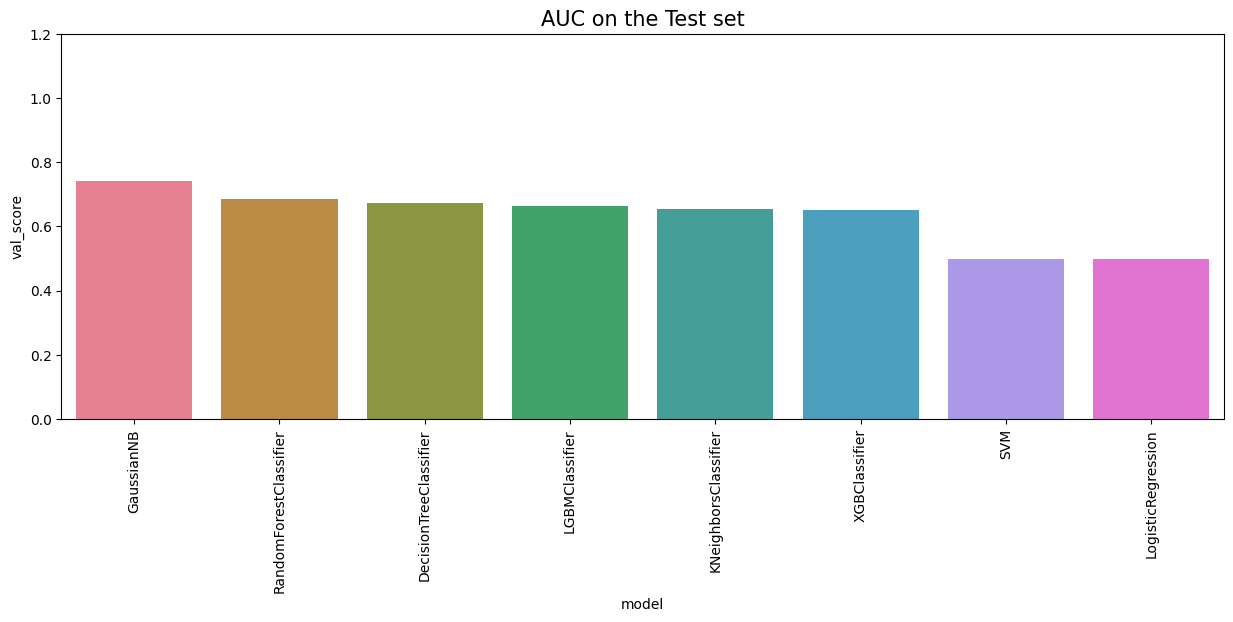

In [189]:
check_performance_for_model(df_results, version='val_score')

## 3. tsne-pca50

In [190]:
X = train_copy[['tsne-pca50-one', 'tsne-pca50-two']]
y = train_copy["Class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((1410, 2), (353, 2), (1410,), (353,))

In [191]:
df_results = experiments(X_train, y_train, X_valid, y_valid)

df_results

KNeighborsClassifier trained in 0.0 sec, val_score: 0.6162667607621737
GaussianNB           trained in 0.0 sec, val_score: 0.5
SVM                  trained in 0.1 sec, val_score: 0.5
DecisionTreeClassifier trained in 0.01 sec, val_score: 0.6778993178075747
LogisticRegression   trained in 0.0 sec, val_score: 0.5
RandomForestClassifier trained in 0.27 sec, val_score: 0.6739590684544813
XGBClassifier        trained in 0.06 sec, val_score: 0.6577864031992473
LGBMClassifier       trained in 0.04 sec, val_score: 0.6531992472359446


,model,val_score,Training time (sec)
0,DecisionTreeClassifier,0.677899,0.01
1,RandomForestClassifier,0.673959,0.27
2,XGBClassifier,0.657786,0.06
3,LGBMClassifier,0.653199,0.04
4,KNeighborsClassifier,0.616267,0.00
5,GaussianNB,0.500000,0.00
6,SVM,0.500000,0.10
7,LogisticRegression,0.500000,0.00


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


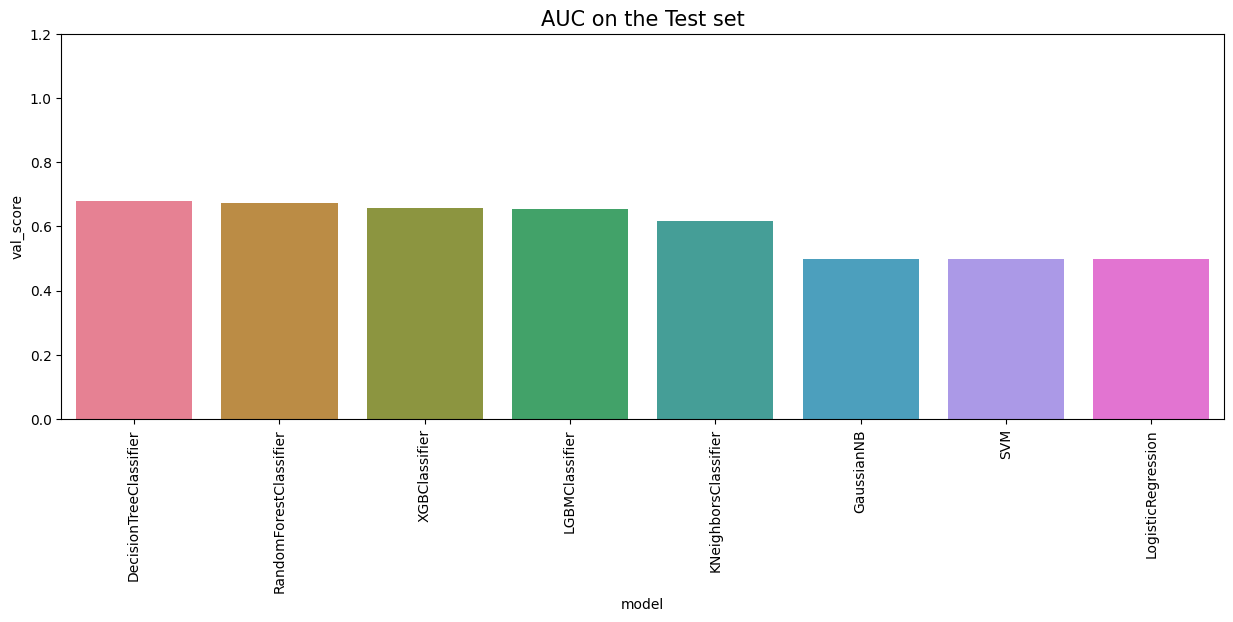

In [192]:
check_performance_for_model(df_results, version='val_score')

## 4. 축소한 차원 다 사용하기 

In [193]:
select_cols = ['pca-one', 'pca-two', 'pca-three', 'tsne-2d-one', 'tsne-2d-two', 'tsne-pca50-one', 'tsne-pca50-two']

X = train_copy[select_cols]
y = train_copy["Class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((1410, 7), (353, 7), (1410,), (353,))

In [194]:
df_results = experiments(X_train, y_train, X_valid, y_valid)

df_results

KNeighborsClassifier trained in 0.0 sec, val_score: 0.6577864031992473
GaussianNB           trained in 0.0 sec, val_score: 0.774935309338979
SVM                  trained in 0.09 sec, val_score: 0.5
DecisionTreeClassifier trained in 0.01 sec, val_score: 0.6956010350505764
LogisticRegression   trained in 0.05 sec, val_score: 0.5900376382027758


c:\Users\kim_h\anaconda3\envs\data\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier trained in 0.42 sec, val_score: 0.6870736297341803
XGBClassifier        trained in 0.07 sec, val_score: 0.6855445777464126
LGBMClassifier       trained in 0.04 sec, val_score: 0.7108915549282522


,model,val_score,Training time (sec)
0,GaussianNB,0.774935,0.00
1,LGBMClassifier,0.710892,0.04
2,DecisionTreeClassifier,0.695601,0.01
3,RandomForestClassifier,0.687074,0.42
4,XGBClassifier,0.685545,0.07
5,KNeighborsClassifier,0.657786,0.00
6,LogisticRegression,0.590038,0.05
7,SVM,0.500000,0.09


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


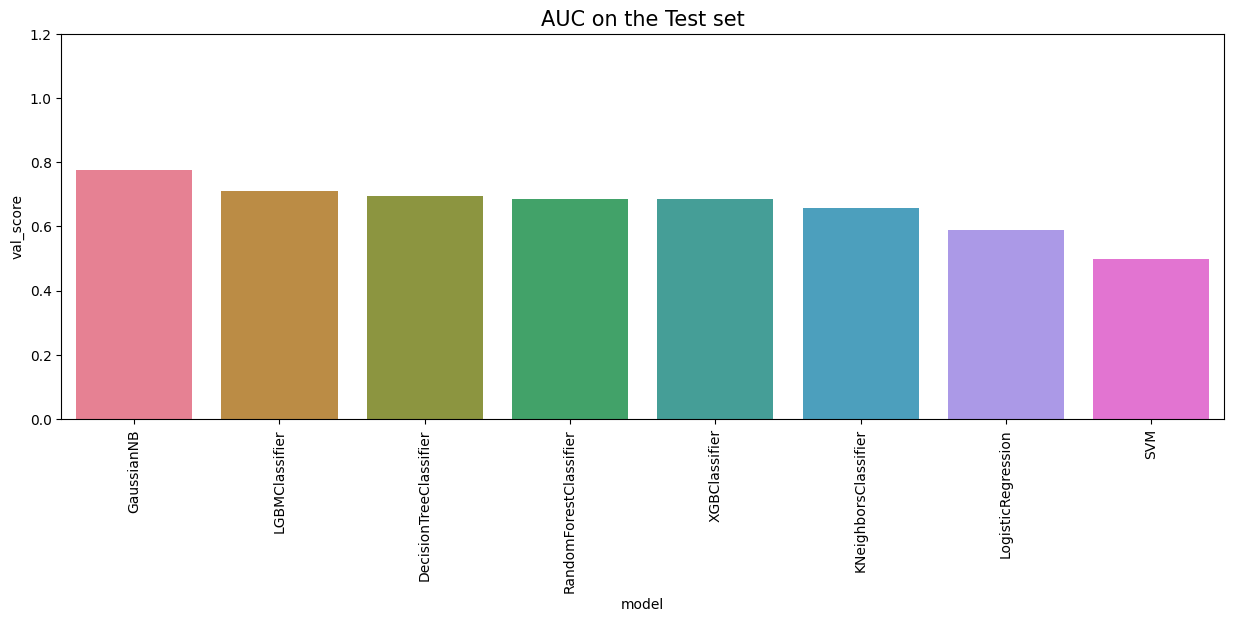

In [195]:
check_performance_for_model(df_results, version='val_score')

### 결론 

PCA로3개를 추출한 컬럼이 무조건 들어가야 성능이 가장 좋았다.

## 차원 축소하고 Oversampling을 해보자 

다음으로는 Ovwersampling을 하고 차원을 축소해보자.



In [196]:
from time import perf_counter

def experiments(x_train_re, y_train_re, x_valid_re, y_valid_re, X_valid, y_valid):

    # Train모델 학습
    for name, model in models.items():
        model = model['model']
        start = perf_counter()

        history = model.fit(x_train_re, y_train_re)

        # 학습시간과 val_accuracy 저장
        duration = perf_counter() - start
        duration = round(duration,2)
        models[name]['perf'] = duration

        y_val_re_pred = model.predict(x_valid_re)
        y_val_pred = model.predict(X_valid)

        val_re_score = roc_auc_score(y_valid_re, y_val_re_pred)
        val_score = roc_auc_score(y_valid, y_val_pred)

        models[name]['val_re_score'] = val_re_score
        models[name]['val_score'] = val_score

        print(f"{name:20} trained in {duration} sec, val_re_score: {val_re_score}, val_score: {val_score}")

    # Create a DataFrame with the results
    models_result = []

    for name, v in models.items():
        models_result.append([ name, models[name]['val_re_score'], models[name]['val_score'], 
                            models[name]['perf']])

    df_results = pd.DataFrame(models_result, 
                            columns = ['model','val_re_score','val_score','Training time (sec)'])
    df_results.sort_values(by='val_score', ascending=False, inplace=True)
    df_results.reset_index(inplace=True,drop=True)
    
    return df_results

### 1. t-sne

In [197]:
X = train_copy[['tsne-2d-one', 'tsne-2d-two']]
y = train_copy["Class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

Sm = SMOTE()
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape, y_train.value_counts()


x_train_re, x_valid_re, y_train_re, y_valid_re = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

x_train_re.shape, x_valid_re.shape, y_train_re.shape, y_valid_re.shape



((2068, 2), (518, 2), (2068,), (518,))

In [198]:
df_results = experiments(x_train_re, y_train_re, x_valid_re, y_valid_re, X_valid, y_valid)

df_results

KNeighborsClassifier trained in 0.0 sec, val_re_score: 0.8850607426936501, val_score: 0.7821689014349564
GaussianNB           trained in 0.0 sec, val_re_score: 0.69980676183771, val_score: 0.7024229593036933
SVM                  trained in 0.4 sec, val_re_score: 0.7410084335725092, val_score: 0.7712302987532346
DecisionTreeClassifier trained in 0.01 sec, val_re_score: 0.8755785910091826, val_score: 0.668960244648318
LogisticRegression   trained in 0.0 sec, val_re_score: 0.6824827358928652, val_score: 0.6993648553281581
RandomForestClassifier trained in 0.43 sec, val_re_score: 0.8985874140539569, val_score: 0.7373559162549989
XGBClassifier        trained in 0.06 sec, val_re_score: 0.8905582935122909, val_score: 0.7828158080451659
LGBMClassifier       trained in 0.04 sec, val_re_score: 0.9047290920802313, val_score: 0.8020465772759351


,model,val_re_score,val_score,Training time (sec)
0,LGBMClassifier,0.904729,0.802047,0.04
1,XGBClassifier,0.890558,0.782816,0.06
2,KNeighborsClassifier,0.885061,0.782169,0.00
3,SVM,0.741008,0.771230,0.40
4,RandomForestClassifier,0.898587,0.737356,0.43
5,GaussianNB,0.699807,0.702423,0.00
6,LogisticRegression,0.682483,0.699365,0.00
7,DecisionTreeClassifier,0.875579,0.668960,0.01


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


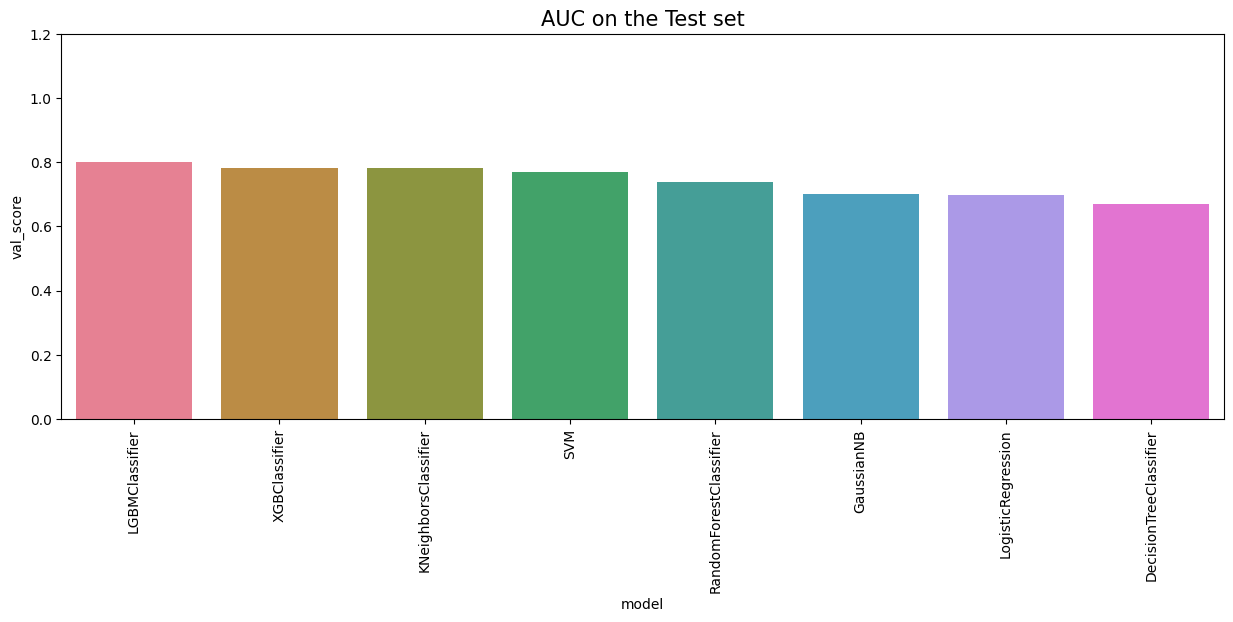

In [199]:
check_performance_for_model(df_results, version='val_score')

## 2. pca

In [200]:
X = train_copy[['pca-one', 'pca-two', 'pca-three']]
y = train_copy["Class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

Sm = SMOTE()
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape, y_train.value_counts()


x_train_re, x_valid_re, y_train_re, y_valid_re = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

x_train_re.shape, x_valid_re.shape, y_train_re.shape, y_valid_re.shape


((2068, 3), (518, 3), (2068,), (518,))

In [201]:
df_results = experiments(x_train_re, y_train_re, x_valid_re, y_valid_re, X_valid, y_valid)

df_results

KNeighborsClassifier trained in 0.0 sec, val_re_score: 0.8961607022484533, val_score: 0.7629381322041873
GaussianNB           trained in 0.0 sec, val_re_score: 0.720988061177105, val_score: 0.7428252175958597
SVM                  trained in 0.39 sec, val_re_score: 0.7382072292044279, val_score: 0.7742884027287696
DecisionTreeClassifier trained in 0.02 sec, val_re_score: 0.8909103165211139, val_score: 0.6943072218301576
LogisticRegression   trained in 0.01 sec, val_re_score: 0.7327096783857873, val_score: 0.7627028934368384
RandomForestClassifier trained in 0.41 sec, val_re_score: 0.9081519541021915, val_score: 0.7450011761938368
XGBClassifier        trained in 0.06 sec, val_re_score: 0.9042722111538865, val_score: 0.7428252175958597
LGBMClassifier       trained in 0.05 sec, val_re_score: 0.902467157002262, val_score: 0.7535285815102328


,model,val_re_score,val_score,Training time (sec)
0,SVM,0.738207,0.774288,0.39
1,KNeighborsClassifier,0.896161,0.762938,0.00
2,LogisticRegression,0.732710,0.762703,0.01
3,LGBMClassifier,0.902467,0.753529,0.05
4,RandomForestClassifier,0.908152,0.745001,0.41
5,GaussianNB,0.720988,0.742825,0.00
6,XGBClassifier,0.904272,0.742825,0.06
7,DecisionTreeClassifier,0.890910,0.694307,0.02


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


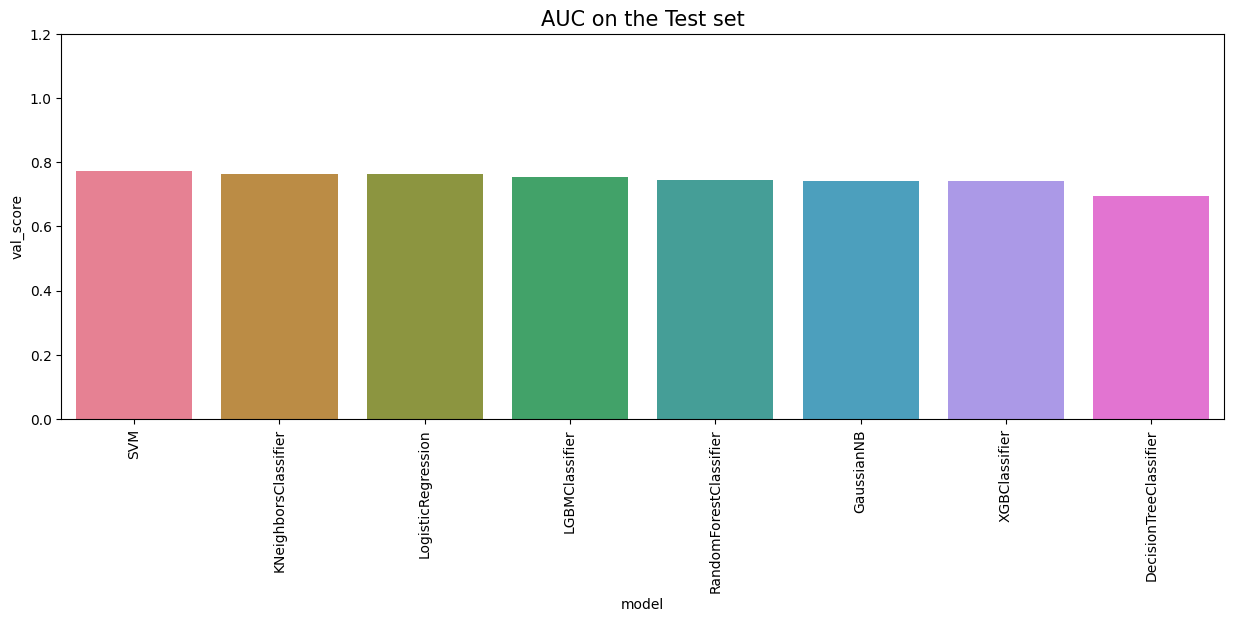

In [202]:
check_performance_for_model(df_results, version='val_score')

## 3. tsne-pca50

In [203]:
X = train_copy[['tsne-pca50-one', 'tsne-pca50-two']]
y = train_copy["Class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

Sm = SMOTE()
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape, y_train.value_counts()


x_train_re, x_valid_re, y_train_re, y_valid_re = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

x_train_re.shape, x_valid_re.shape, y_train_re.shape, y_valid_re.shape

((2068, 2), (518, 2), (2068,), (518,))

In [204]:
df_results = experiments(x_train_re, y_train_re, x_valid_re, y_valid_re, X_valid, y_valid)

df_results

KNeighborsClassifier trained in 0.0 sec, val_re_score: 0.8785670416585525, val_score: 0.8105739825923312
GaussianNB           trained in 0.0 sec, val_re_score: 0.6559461929086088, val_score: 0.7054810632792284
SVM                  trained in 0.4 sec, val_re_score: 0.7701814041973126, val_score: 0.7470007057163021
DecisionTreeClassifier trained in 0.01 sec, val_re_score: 0.8797279686025435, val_score: 0.7196541990119971
LogisticRegression   trained in 0.0 sec, val_re_score: 0.6437676947735819, val_score: 0.6901905434015525
RandomForestClassifier trained in 0.43 sec, val_re_score: 0.9063468999505668, val_score: 0.7281816043283933
XGBClassifier        trained in 0.06 sec, val_re_score: 0.898317779408901, val_score: 0.708950835097624
LGBMClassifier       trained in 0.04 sec, val_re_score: 0.8998531989154696, val_score: 0.708950835097624


,model,val_re_score,val_score,Training time (sec)
0,KNeighborsClassifier,0.878567,0.810574,0.00
1,SVM,0.770181,0.747001,0.40
2,RandomForestClassifier,0.906347,0.728182,0.43
3,DecisionTreeClassifier,0.879728,0.719654,0.01
4,XGBClassifier,0.898318,0.708951,0.06
5,LGBMClassifier,0.899853,0.708951,0.04
6,GaussianNB,0.655946,0.705481,0.00
7,LogisticRegression,0.643768,0.690191,0.00


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


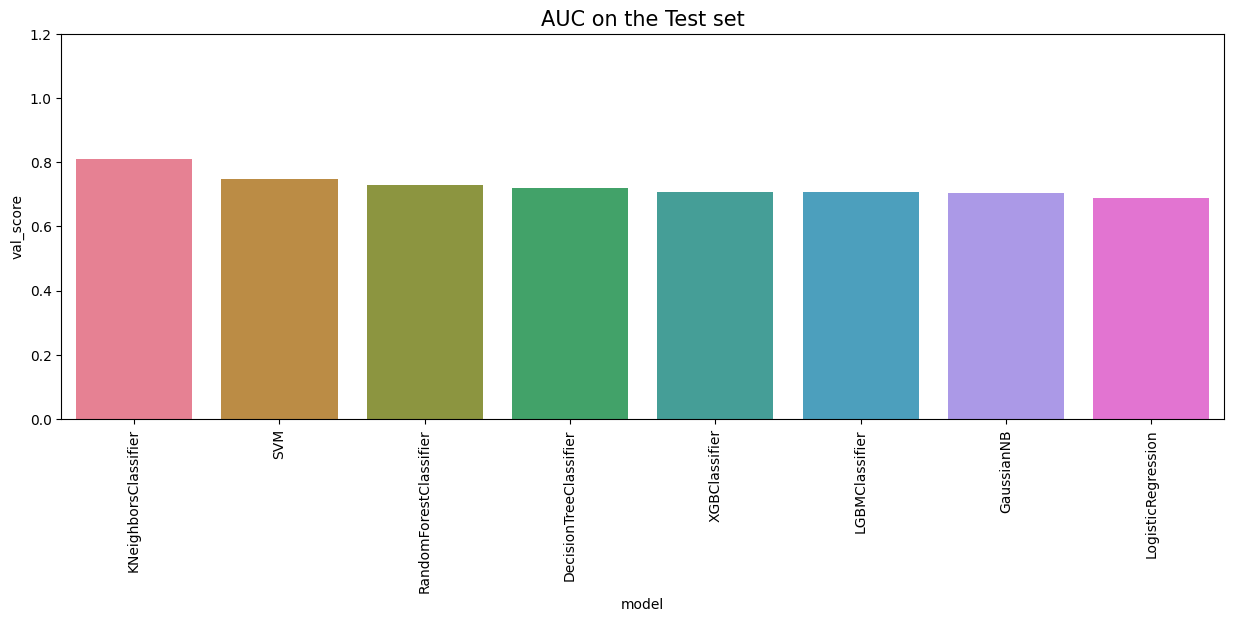

In [205]:
check_performance_for_model(df_results, version='val_score')

## 4. 축소한 차원 다 사용하기 

In [206]:
select_cols = ['pca-one', 'pca-two', 'pca-three', 'tsne-2d-one', 'tsne-2d-two', 'tsne-pca50-one', 'tsne-pca50-two']

X = train_copy[select_cols]
y = train_copy["Class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

Sm = SMOTE()
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape, y_train.value_counts()


x_train_re, x_valid_re, y_train_re, y_valid_re = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

x_train_re.shape, x_valid_re.shape, y_train_re.shape, y_valid_re.shape

((2068, 7), (518, 7), (2068,), (518,))

In [207]:
df_results = experiments(x_train_re, y_train_re, x_valid_re, y_valid_re, X_valid, y_valid)

df_results

KNeighborsClassifier trained in 0.0 sec, val_re_score: 0.8785670416585525, val_score: 0.8129851799576571
GaussianNB           trained in 0.0 sec, val_re_score: 0.7055514777476519, val_score: 0.7351799576570219
SVM                  trained in 0.44 sec, val_re_score: 0.7294515930913612, val_score: 0.7758174547165373
DecisionTreeClassifier trained in 0.03 sec, val_re_score: 0.910496277543928, val_score: 0.6827217125382263
LogisticRegression   trained in 0.04 sec, val_re_score: 0.7283131357011249, val_score: 0.7592331216184428
RandomForestClassifier trained in 0.68 sec, val_re_score: 0.9153721707086897, val_score: 0.7334156669019054
XGBClassifier        trained in 0.08 sec, val_re_score: 0.9130278472669532, val_score: 0.7095977417078334
LGBMClassifier       trained in 0.04 sec, val_re_score: 0.9094177389637041, val_score: 0.7272994589508351


,model,val_re_score,val_score,Training time (sec)
0,KNeighborsClassifier,0.878567,0.812985,0.00
1,SVM,0.729452,0.775817,0.44
2,LogisticRegression,0.728313,0.759233,0.04
3,GaussianNB,0.705551,0.735180,0.00
4,RandomForestClassifier,0.915372,0.733416,0.68
5,LGBMClassifier,0.909418,0.727299,0.04
6,XGBClassifier,0.913028,0.709598,0.08
7,DecisionTreeClassifier,0.910496,0.682722,0.03


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


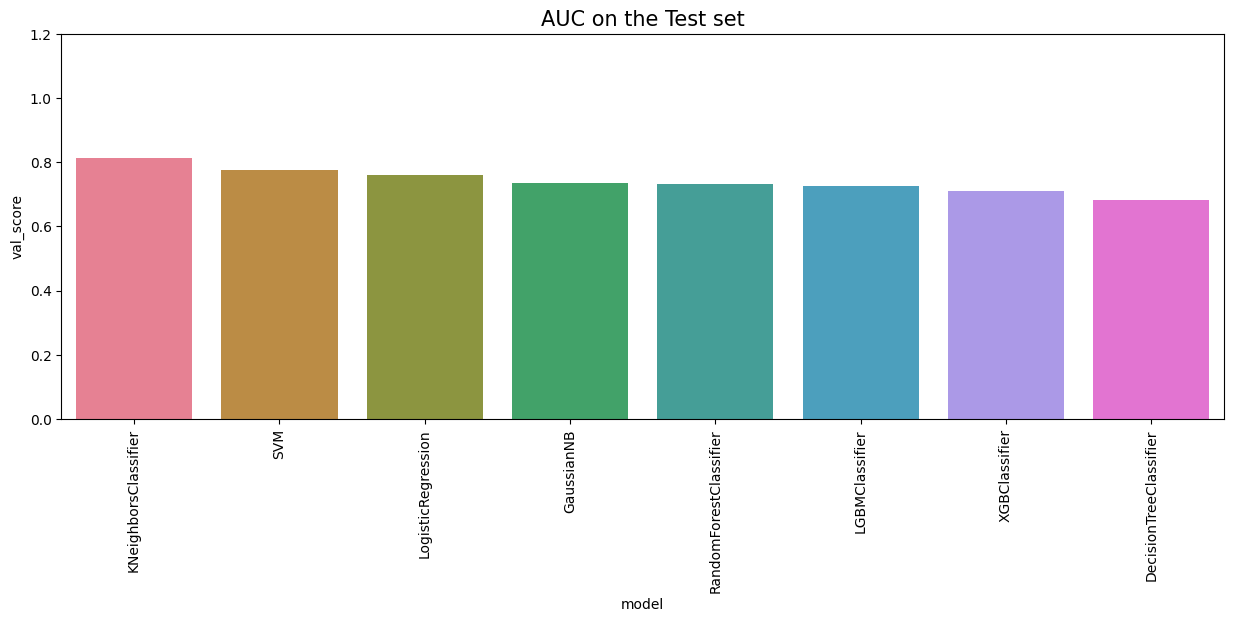

In [208]:
check_performance_for_model(df_results, version='val_score')

## 이번에는 Oversampling 이후 차원을 축소해서 실험을 진행해보자

In [209]:
Sm = SMOTE()
X = train.drop("Class", axis = 1)
y = train["Class"]

In [210]:
x_train, y_train = Sm.fit_resample(X, y)
x_train.shape, y_train.shape, y_train.value_counts()

((3240, 1558),
 (3240,),
 Class
 0    1620
 1    1620
 Name: count, dtype: int64)

In [211]:
x_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [212]:
# n_components 는 축소하고 싶은 차원의 수, 주성분을 몇개로 할지 결정
pca = PCA(n_components=3, random_state=52)

pca_result = pca.fit_transform(x_train)

print(pca.explained_variance_ratio_)

[9.38921203e-01 6.05841334e-02 2.17062523e-04]


In [213]:
train_copy = x_train.copy()
# 주요 성분 3개 
train_copy['pca-one'] = pca_result[:,0]
train_copy['pca-two'] = pca_result[:,1] 
train_copy['pca-three'] = pca_result[:,2]

In [214]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train)

train_copy['tsne-2d-one'] = tsne_results[:,0]
train_copy['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3240 samples in 0.027s...
[t-SNE] Computed neighbors for 3240 samples in 0.239s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3240
[t-SNE] Computed conditional probabilities for sample 2000 / 3240
[t-SNE] Computed conditional probabilities for sample 3000 / 3240
[t-SNE] Computed conditional probabilities for sample 3240 / 3240
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.047829
[t-SNE] KL divergence after 300 iterations: 1.201234


In [215]:
pca_50 = PCA(n_components=50)               # 차원을 50개로 줄임 
pca_result_50 = pca_50.fit_transform(x_train)

# 2차원 공간으로 변환
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_pca_results = tsne.fit_transform(pca_result_50)

train_copy['tsne-pca50-one'] = tsne_pca_results[:,0]
train_copy['tsne-pca50-two'] = tsne_pca_results[:,1]

## 1. t-sne

In [216]:
X = train_copy[['tsne-2d-one', 'tsne-2d-two']]
y2 = y_train.copy()

In [217]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y2, test_size = 0.4, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = 0.5, random_state=0)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((1944, 2), (648, 2), (648, 2), (1944,), (648,), (648,))

In [218]:
df_results = experiments(X_train, y_train, X_valid, y_valid, X_test, y_test)

df_results

KNeighborsClassifier trained in 0.0 sec, val_re_score: 0.8768423968592088, val_score: 0.8773013150371642
GaussianNB           trained in 0.0 sec, val_re_score: 0.6683494607735441, val_score: 0.662292738707833
SVM                  trained in 0.38 sec, val_re_score: 0.7716430884446015, val_score: 0.7988279016580904
DecisionTreeClassifier trained in 0.01 sec, val_re_score: 0.8711492353396315, val_score: 0.8967695826186393
LogisticRegression   trained in 0.0 sec, val_re_score: 0.6618300266508735, val_score: 0.65494568324757
RandomForestClassifier trained in 0.37 sec, val_re_score: 0.8879278229388557, val_score: 0.9104059462550028
XGBClassifier        trained in 0.06 sec, val_re_score: 0.8814083888161854, val_score: 0.8889079473985134
LGBMClassifier       trained in 0.04 sec, val_re_score: 0.8950920362604716, val_score: 0.8780731846769583


,model,val_re_score,val_score,Training time (sec)
0,RandomForestClassifier,0.887928,0.910406,0.37
1,DecisionTreeClassifier,0.871149,0.896770,0.01
2,XGBClassifier,0.881408,0.888908,0.06
3,LGBMClassifier,0.895092,0.878073,0.04
4,KNeighborsClassifier,0.876842,0.877301,0.00
5,SVM,0.771643,0.798828,0.38
6,GaussianNB,0.668349,0.662293,0.00
7,LogisticRegression,0.661830,0.654946,0.00


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


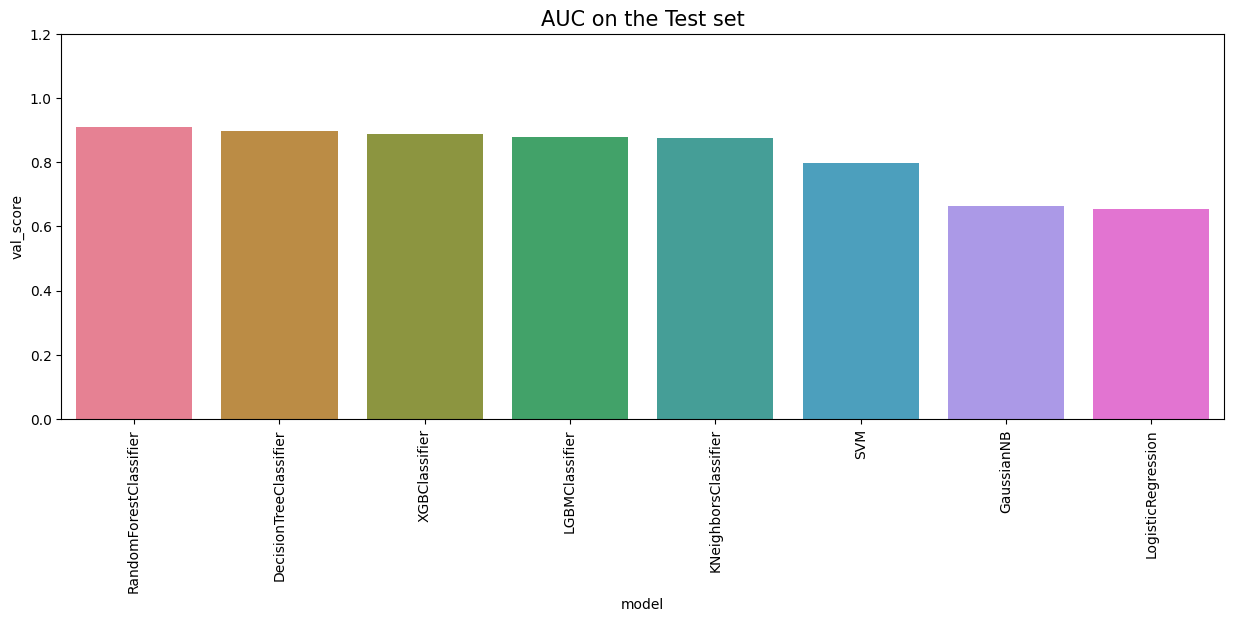

In [219]:
check_performance_for_model(df_results, version='val_score')

## 2. pca

In [220]:
X = train_copy[['pca-one', 'pca-two', 'pca-three']]

X_train, X_valid, y_train, y_valid = train_test_split(X, y2, test_size = 0.4, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = 0.5, random_state=0)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((1944, 3), (648, 3), (648, 3), (1944,), (648,), (648,))

In [221]:
df_results = experiments(X_train, y_train, X_valid, y_valid, X_test, y_test)

df_results

KNeighborsClassifier trained in 0.0 sec, val_re_score: 0.8815660015092608, val_score: 0.8866781017724414
GaussianNB           trained in 0.0 sec, val_re_score: 0.6182954903665212, val_score: 0.6026014865637508
SVM                  trained in 0.35 sec, val_re_score: 0.7462340118639373, val_score: 0.7551457975986277
DecisionTreeClassifier trained in 0.01 sec, val_re_score: 0.8711492353396315, val_score: 0.8968839336763865
LogisticRegression   trained in 0.01 sec, val_re_score: 0.7235903216254168, val_score: 0.749028016009148
RandomForestClassifier trained in 0.33 sec, val_re_score: 0.9025858033948819, val_score: 0.9060891938250429
XGBClassifier        trained in 0.07 sec, val_re_score: 0.9016066942409278, val_score: 0.9031160663236135
LGBMClassifier       trained in 0.04 sec, val_re_score: 0.9077965745508039, val_score: 0.8971698113207547


,model,val_re_score,val_score,Training time (sec)
0,RandomForestClassifier,0.902586,0.906089,0.33
1,XGBClassifier,0.901607,0.903116,0.07
2,LGBMClassifier,0.907797,0.897170,0.04
3,DecisionTreeClassifier,0.871149,0.896884,0.01
4,KNeighborsClassifier,0.881566,0.886678,0.00
5,SVM,0.746234,0.755146,0.35
6,LogisticRegression,0.723590,0.749028,0.01
7,GaussianNB,0.618295,0.602601,0.00


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


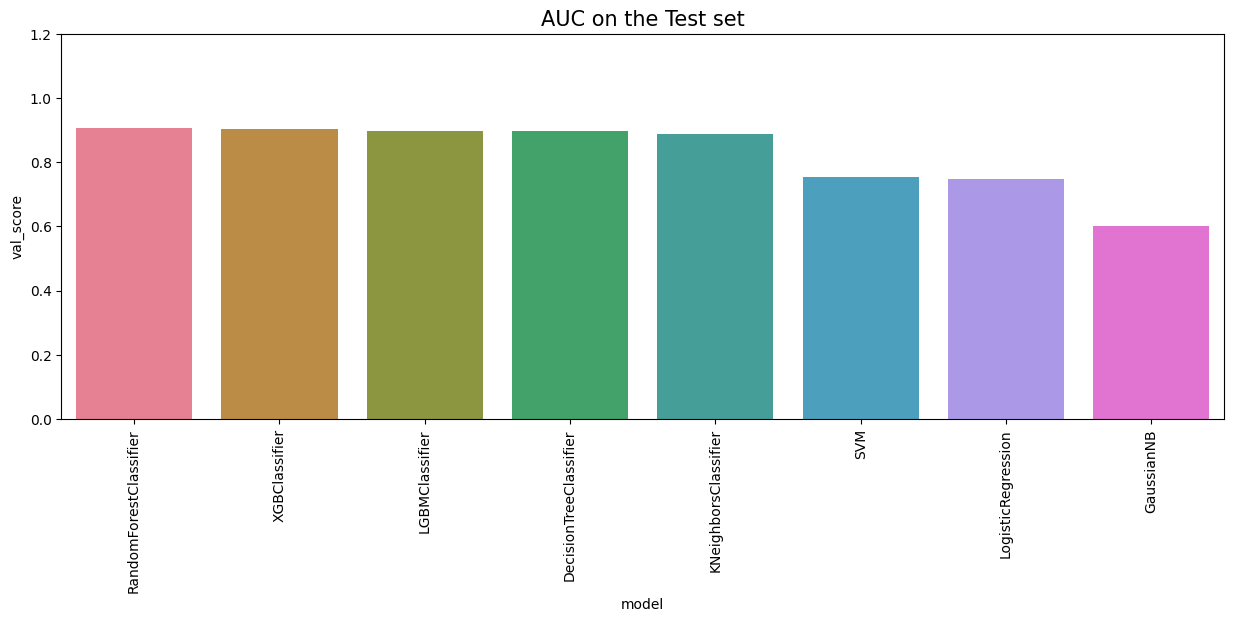

In [222]:
check_performance_for_model(df_results, version='val_score')

## 3. tsne-pca50

In [223]:
X = train_copy[['tsne-pca50-one', 'tsne-pca50-two']]

X_train, X_valid, y_train, y_valid = train_test_split(X, y2, test_size = 0.4, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = 0.5, random_state=0)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((1944, 2), (648, 2), (648, 2), (1944,), (648,), (648,))

In [224]:
df_results = experiments(X_train, y_train, X_valid, y_valid, X_test, y_test)

df_results

KNeighborsClassifier trained in 0.0 sec, val_re_score: 0.8768423968592088, val_score: 0.8761292166952546
GaussianNB           trained in 0.0 sec, val_re_score: 0.7429575783048515, val_score: 0.7252144082332761
SVM                  trained in 0.36 sec, val_re_score: 0.787108236934863, val_score: 0.7969982847341338
DecisionTreeClassifier trained in 0.01 sec, val_re_score: 0.8763600064955533, val_score: 0.9043453401943968
LogisticRegression   trained in 0.0 sec, val_re_score: 0.7548453962765195, val_score: 0.7238136077758719
RandomForestClassifier trained in 0.36 sec, val_re_score: 0.9014443054056377, val_score: 0.9198970840480274
XGBClassifier        trained in 0.06 sec, val_re_score: 0.8716364018455014, val_score: 0.8999714122355632
LGBMClassifier       trained in 0.04 sec, val_re_score: 0.8761976176602635, val_score: 0.9012006861063465


,model,val_re_score,val_score,Training time (sec)
0,RandomForestClassifier,0.901444,0.919897,0.36
1,DecisionTreeClassifier,0.876360,0.904345,0.01
2,LGBMClassifier,0.876198,0.901201,0.04
3,XGBClassifier,0.871636,0.899971,0.06
4,KNeighborsClassifier,0.876842,0.876129,0.00
5,SVM,0.787108,0.796998,0.36
6,GaussianNB,0.742958,0.725214,0.00
7,LogisticRegression,0.754845,0.723814,0.00


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


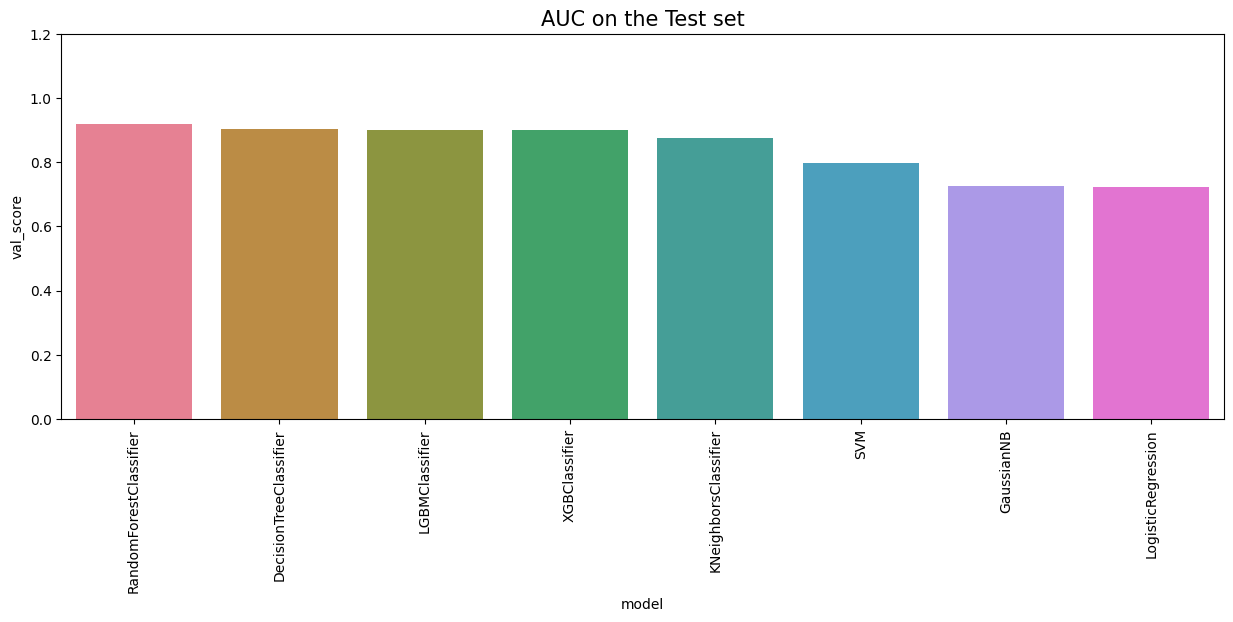

In [225]:
check_performance_for_model(df_results, version='val_score')

## 4. 축소한 차원 다 사용하기 

In [226]:
select_cols = ['pca-one', 'pca-two', 'pca-three', 'tsne-2d-one', 'tsne-2d-two', 'tsne-pca50-one', 'tsne-pca50-two']

X = train_copy[select_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y2, test_size = 0.4, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = 0.5, random_state=0)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((1944, 7), (648, 7), (648, 7), (1944,), (648,), (648,))

In [227]:
df_results = experiments(X_train, y_train, X_valid, y_valid, X_test, y_test)

df_results

KNeighborsClassifier trained in 0.01 sec, val_re_score: 0.8770047856944987, val_score: 0.8821326472269869
GaussianNB           trained in 0.0 sec, val_re_score: 0.7276309379388081, val_score: 0.7008290451686678
SVM                  trained in 0.39 sec, val_re_score: 0.7923190080907849, val_score: 0.7600628930817611
DecisionTreeClassifier trained in 0.02 sec, val_re_score: 0.8929762052594877, val_score: 0.9133790737564322
LogisticRegression   trained in 0.03 sec, val_re_score: 0.7354733634548701, val_score: 0.7458547741566609
RandomForestClassifier trained in 0.58 sec, val_re_score: 0.9014443054056377, val_score: 0.9168667810177243
XGBClassifier        trained in 0.08 sec, val_re_score: 0.9025858033948819, val_score: 0.9198970840480274
LGBMClassifier       trained in 0.04 sec, val_re_score: 0.8954168139310515, val_score: 0.9154088050314465


,model,val_re_score,val_score,Training time (sec)
0,XGBClassifier,0.902586,0.919897,0.08
1,RandomForestClassifier,0.901444,0.916867,0.58
2,LGBMClassifier,0.895417,0.915409,0.04
3,DecisionTreeClassifier,0.892976,0.913379,0.02
4,KNeighborsClassifier,0.877005,0.882133,0.01
5,SVM,0.792319,0.760063,0.39
6,LogisticRegression,0.735473,0.745855,0.03
7,GaussianNB,0.727631,0.700829,0.00


C:\Users\kim_h\AppData\Local\Temp\ipykernel_9356\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


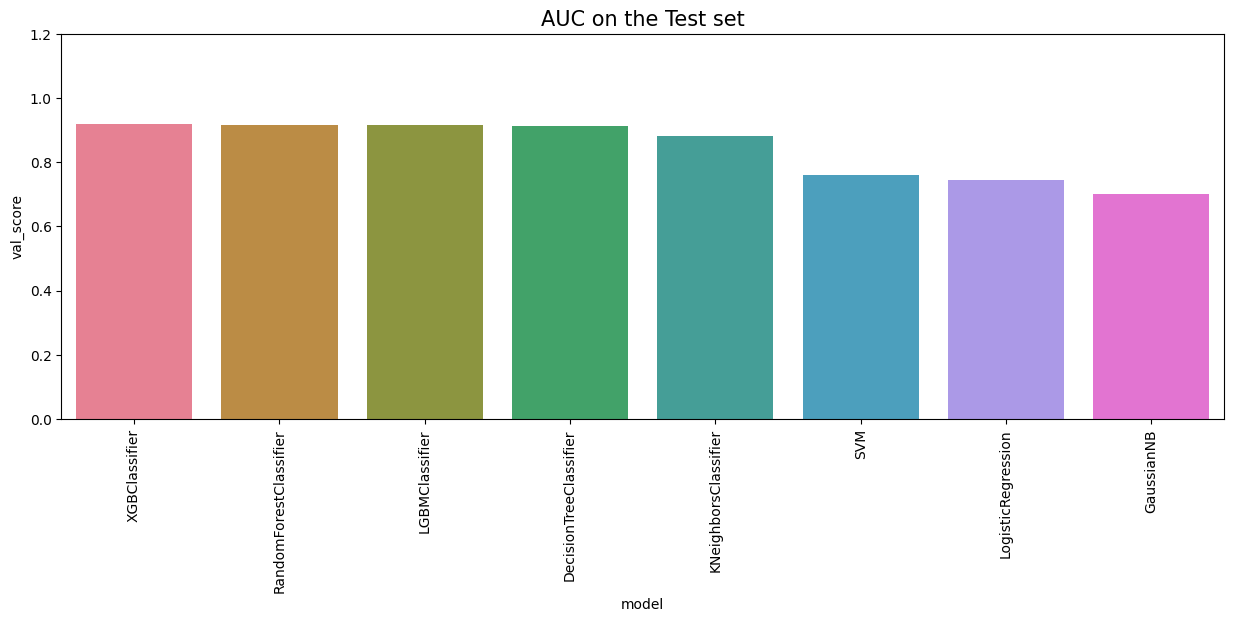

In [228]:
check_performance_for_model(df_results, version='val_score')

# 최종 결론 

불균형한 이진 클래스이고 features들이 굉장히 많은 데이터셋의 경우 

1. Oversampling을 진행한다.

2. PCA, t-SNE를 통해 features들을 결합해 차원을 줄인다.

3. 결합 한 주요 feature들을 입력받는 ML을 구축한다. 

이 경우 가장 좋은 성능을 보인다.

